<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Classification%20Problems/Heart_Disease_binary_classification_using_TENSORFLOW_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict whether a patient has a heart disease (binary classification).

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

## Download the data

In [2]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"

df = pd.read_csv(file_url)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:
# check for null values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
# shape of dataframe
print('Shape of dataframe ', df.shape)

Shape of dataframe  (303, 14)


In [5]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## Split the data into train and validation

In [6]:
val_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(val_df.index)

In [7]:
print('Shape of training dataframe', train_df.shape)
print('Shape of valdataion dataframe', val_df.shape)

Shape of training dataframe (242, 14)
Shape of valdataion dataframe (61, 14)


## Generate `tf.data.Dataset` objects for each dataframe

In [8]:
# utility fn to generate tf.data.Dataset objects for each dataframe:

def df_to_ds(df):
  df = df.copy()
  labels = df.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(df),labels))
  ds = ds.shuffle(buffer_size = len(df))
  return ds

In [9]:
# create training and validation dataset
train_ds = df_to_ds(train_df)
val_ds = df_to_ds(val_df)

In [10]:
features, labels = next(iter(train_ds))

for key, val in features.items():
  print(key ,"------", val)

age ------ tf.Tensor(70, shape=(), dtype=int64)
sex ------ tf.Tensor(1, shape=(), dtype=int64)
cp ------ tf.Tensor(2, shape=(), dtype=int64)
trestbps ------ tf.Tensor(156, shape=(), dtype=int64)
chol ------ tf.Tensor(245, shape=(), dtype=int64)
fbs ------ tf.Tensor(0, shape=(), dtype=int64)
restecg ------ tf.Tensor(2, shape=(), dtype=int64)
thalach ------ tf.Tensor(143, shape=(), dtype=int64)
exang ------ tf.Tensor(0, shape=(), dtype=int64)
oldpeak ------ tf.Tensor(0.0, shape=(), dtype=float64)
slope ------ tf.Tensor(1, shape=(), dtype=int64)
ca ------ tf.Tensor(0, shape=(), dtype=int64)
thal ------ tf.Tensor(b'normal', shape=(), dtype=string)


lets Batch the dataset

In [11]:
train_ds = train_ds.batch(batch_size=32)
val_ds = val_ds.batch(batch_size=32)

## Feature preprocessing with Keras layers

In [34]:
for col in df.columns:
  print(f'Column {col:20} Dtype {df[col].dtype} \t number of Unique values {len(df[col].unique())}')

Column age                  Dtype int64 	 number of Unique values 41
Column sex                  Dtype int64 	 number of Unique values 2
Column cp                   Dtype int64 	 number of Unique values 5
Column trestbps             Dtype int64 	 number of Unique values 50
Column chol                 Dtype int64 	 number of Unique values 152
Column fbs                  Dtype int64 	 number of Unique values 2
Column restecg              Dtype int64 	 number of Unique values 3
Column thalach              Dtype int64 	 number of Unique values 91
Column exang                Dtype int64 	 number of Unique values 2
Column oldpeak              Dtype float64 	 number of Unique values 40
Column slope                Dtype int64 	 number of Unique values 3
Column ca                   Dtype int64 	 number of Unique values 4
Column thal                 Dtype object 	 number of Unique values 5
Column target               Dtype int64 	 number of Unique values 2


In [44]:
int_cat=[]
str_cat=[]
neu_col=[]
for col in df.columns:
  if col!='target':
      if len(df[col].unique()) < 10:
        if df[col].dtype == 'int64':
          int_cat.append(col)
        else:
          str_cat.append(col)
      else:
        neu_col.append(col)


print('The following features are categorical features encoded as integers:',int_cat)
print('The following features are categorical features encoded as string:',str_cat)
print('The following features are  continuous numerical features:',neu_col)

The following features are categorical features encoded as integers: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca']
The following features are categorical features encoded as string: ['thal']
The following features are  continuous numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


We will encode these features using one-hot encoding. We have two options here:

* Use `CategoryEncoding()`, which requires knowing the range of input values and will error on input outside the range.
* Use `IntegerLookup()` which will build a lookup table for inputs and reserve an output index for unkown input values.

We also have a categorical feature encoded as a `string`: thal. We will create an index of all possible features and encode output using the `StringLookup()` layer.

For each of neumeric features, we will use a `Normalization()` layer to make sure the mean of each feature is `0` and its standard deviation is `1`.

In [96]:
# utility for neumeric features
def encode_neumeric_feature(feature, name, dataset):
  # initialize normalizer
  normalizer = tf.keras.layers.Normalization(name='normalized_'+name)
  # prepare a dataset that only yeilds our feature
  feature_ds = dataset.map(lambda x,y: x[name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
  # adapt Learn the mean and Standard deviation
  normalizer.adapt(feature_ds)
  # normalize the input feature
  return normalizer(feature)

In [97]:
# utility for categorical feature
def encode_categorical_feature(feature, name, dataset, is_string=False):
  # select the lookup class
  lookup_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
  # initialize the lookup class , select output mode to binary
  lookup = lookup_class(output_mode='binary', name='encoded_'+name)
  # prepare a dataset that yeild only our feature
  feature_ds = dataset.map(lambda x,y: x[name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
  # adapt Learn the set of possible values and assign them a fixed integer index
  lookup.adapt(feature_ds)
  # encode category -- Turn the input into integer indices
  return lookup(feature)

## Build the model

In [118]:
# encoding features
all_inputs=[]
encoded_inputs=[]

# Integer categorical features
for feature in int_cat:
  input_feature = tf.keras.Input(shape=(1,), name=feature, dtype='int64' )
  all_inputs.append(input_feature)
  encoded_feature = encode_categorical_feature(feature=input_feature, name=feature, dataset=train_ds, is_string=False)
  encoded_inputs.append(encoded_feature)
# String categorical features
for feature in str_cat:
  input_feature = tf.keras.Input(shape=(1,), name=feature, dtype='string')
  all_inputs.append(input_feature)
  encoded_feature = encode_categorical_feature(feature=input_feature, name=feature, dataset=train_ds, is_string=True)
  encoded_inputs.append(encoded_feature)

# Numerical features
for feature in neu_col:
  input_feature = tf.keras.Input(shape=(1,), name=feature)
  all_inputs.append(input_feature)
  encoded_feature = encode_neumeric_feature(feature=input_feature, name=feature, dataset=train_ds)
  encoded_inputs.append(encoded_feature)

In [119]:
# all inputs 
all_inputs

[<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'sex')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cp')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'fbs')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'restecg')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'exang')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'slope')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'ca')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'thal')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>]

In [128]:
# concatenation of inputs
all_input_features = tf.keras.layers.concatenate(encoded_inputs)
x = tf.keras.layers.Dense(units=32, activation='relu')(all_input_features)
x = tf.keras.layers.Dropout(rate=0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
# compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

**Let's visualize our connectivity graph:**

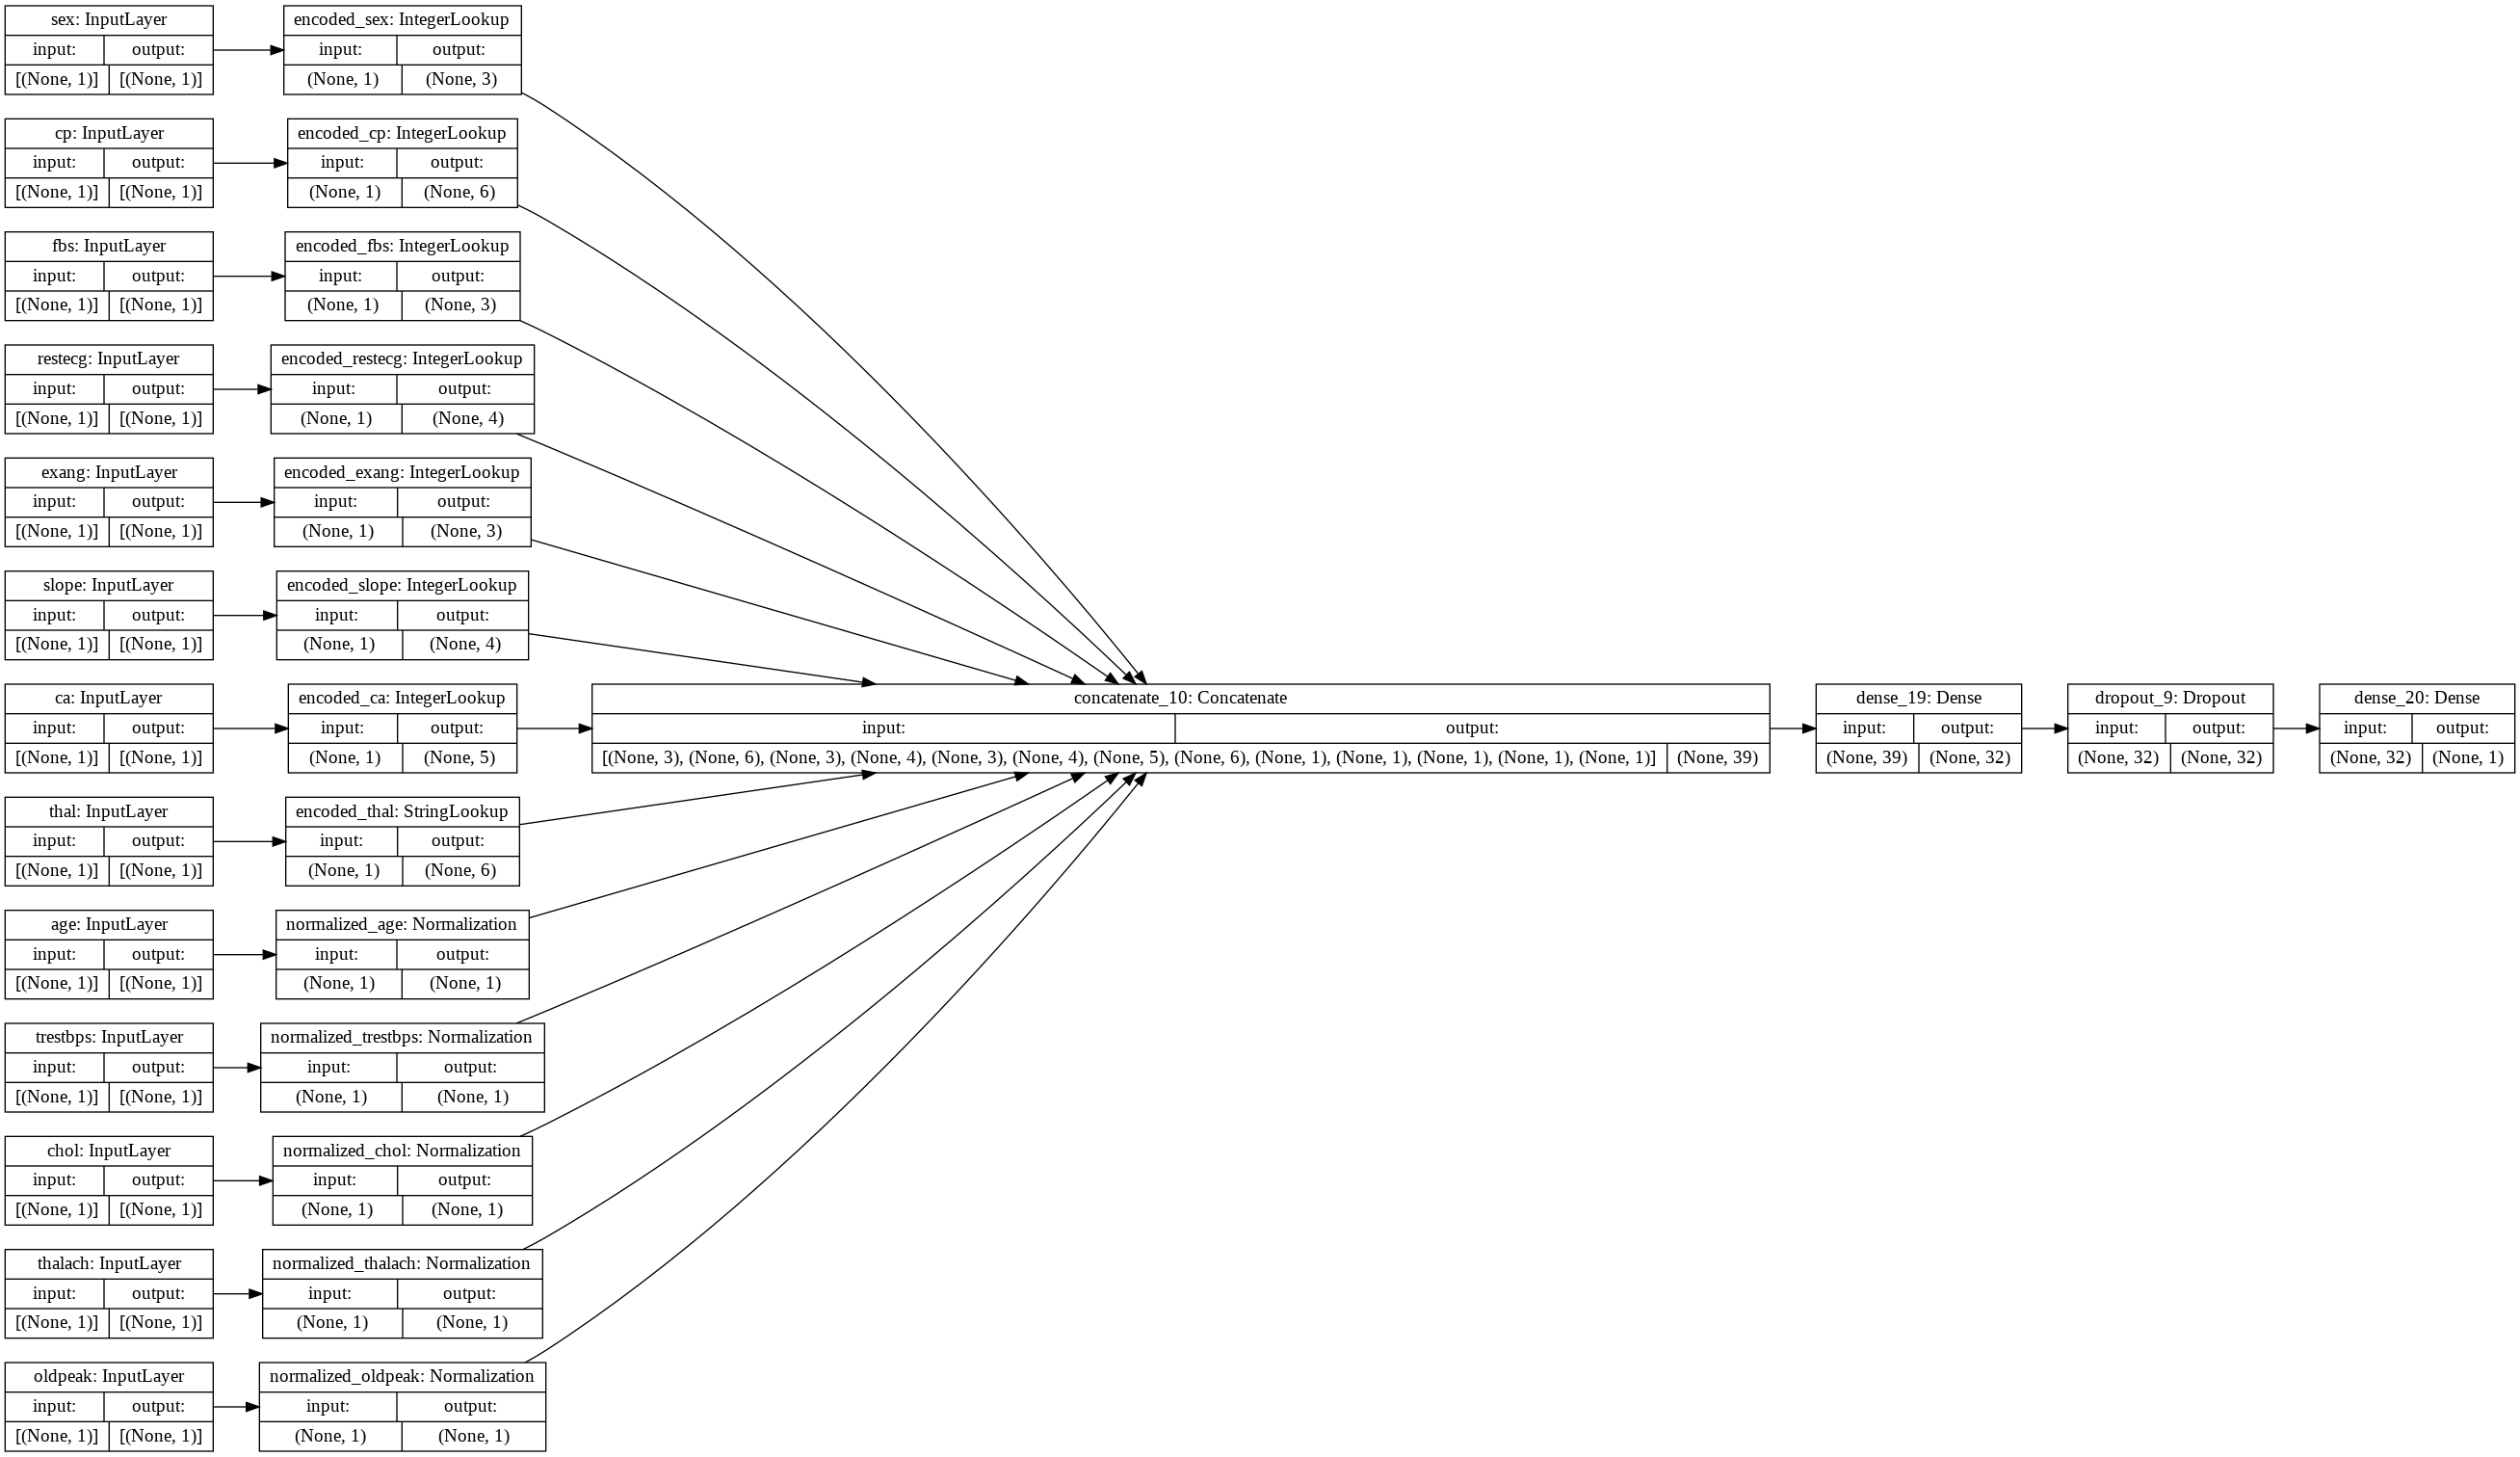

In [124]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

## Train the model

In [129]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 1s 47ms/step - loss: 0.8402 - accuracy: 0.5785 - val_loss: 0.7185 - val_accuracy: 0.7377
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.7574 - accuracy: 0.6364 - val_loss: 0.6481 - val_accuracy: 0.8033
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.7193 - accuracy: 0.6777 - val_loss: 0.5925 - val_accuracy: 0.7705
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6380 - accuracy: 0.7231 - val_loss: 0.5489 - val_accuracy: 0.7541
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5727 - accuracy: 0.7273 - val_loss: 0.5157 - val_accuracy: 0.7541
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5406 - accuracy: 0.7479 - val_loss: 0.4878 - val_accuracy: 0.7705
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5105 - accuracy: 0.7479 - val_loss: 0.4655 - val_accuracy: 0.7705
Epoch 8/50
8/8 [=================

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are just two things you need to do:

* wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
* Call `convert_to_tensor` on each feature

In [130]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

In [131]:
input_dict = {name:tf.convert_to_tensor([val]) for name, val in sample.items()}

predictions = model.predict(input_dict)

In [141]:
predictions_prob = tf.nn.sigmoid(predictions)

In [155]:
print(f'This particular patient had {100*predictions_prob.numpy()[0][0] :.1f} percent probability of having a heart disease, as evaluated by our model.')

This particular patient had 24.5 percent probability of having a heart disease, as evaluated by our model.
